In [153]:
import math
import numpy as np
import pandas as pd 
import seaborn as sns
import os
import matplotlib.pyplot as plt

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [154]:
print(os.listdir())

['.conda', '.condarc', '.continuum', '.ipynb_checkpoints', '.ipython', '.jupyter', '.matplotlib', '.mcu8051ide', '.packettracer', '.spyder-py3', '.vscode', '3D Objects', 'anaconda3', 'AppData', 'Application Data', 'Breast Cancer Wisconsin .ipynb', 'breast-cancer-wiscons.csv', 'Cisco Packet Tracer 8.2.1', 'Cleaned dataset clean again.ipynb', 'Contacts', 'Cookies', 'cpi.csv', 'Documents', 'Downloads', 'EHR-from-mendeley.csv', 'EHR.ipynb', 'Favorites', 'full_data.csv', 'geoProperties.csv', 'geo_attributes.csv', 'healthcare-dataset-stroke-data.csv', 'histFinal.csv', 'House Pricing.csv', 'IntelGraphicsProfiles', 'interest.csv', 'Links', 'Local Settings', 'mcu8051ide_errors.log', 'merged2.csv', 'merged3.csv', 'merged_data.csv', 'Microsoft', 'Music', 'My Documents', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{fd4fe52f-96e2-11ed-9791-a6ed2054544c}.TM.blf', 'NTUSER.DAT{fd4fe52f-96e2-11ed-9791-a6ed2054544c}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{

In [155]:
df = pd.read_csv("EHR-from-mendeley.csv")
EHR = df.copy(deep=True)
target = 'SOURCE'
EHR.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,out
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,out


In [156]:
#Sanity check 
def sanity_check(EHR):
    # Check for duplicate rows
    if EHR.duplicated().sum() > 0:
        print("WARNING: Duplicate rows found in DataFrame.") 
    
    # Check for missing values
    if EHR.isnull().sum().sum() > 0:
        print("WARNING: Missing values found in DataFrame.")

    # Check for negative values (assuming all numeric columns should be non-negative)
    if (EHR.select_dtypes(include=['number']) < 0).sum().sum() > 0:
        print("WARNING: Negative values found in numeric columns.")
    
    # Check for zero values (assuming all numeric columns should be non-zero)
    if (EHR.select_dtypes(include=['number']) == 0).sum().sum() > 0:
        print("WARNING: Zero values found in numeric columns.")
    
    # Check for non-numeric values (assuming all columns should be numeric)
    non_numeric = EHR.apply(lambda s: bool(re.match(r'^[^\d-]+$', str(s))))
    if non_numeric.sum().sum() > 0:
        print("WARNING: Non-numeric values found in DataFrame.")
        
print("Sanity check complete.") 

Sanity check complete.


In [157]:
#Determining missing values 
missing_values = [np.nan]
clean_df= EHR.copy()
missing_count = clean_df.isnull().sum()
missing_bool = clean_df.isnull().any()
missing_df= pd.DataFrame({'Missing Value Count':missing_count, 'Missing Value Availability': missing_bool})
print(missing_df)

              Missing Value Count  Missing Value Availability
HAEMATOCRIT                     0                       False
HAEMOGLOBINS                    0                       False
ERYTHROCYTE                     0                       False
LEUCOCYTE                       0                       False
THROMBOCYTE                     0                       False
MCH                             0                       False
MCHC                            0                       False
MCV                             0                       False
AGE                             0                       False
SEX                             0                       False
SOURCE                          0                       False


In [158]:
#Clean duplicates 
subnet = ['HAEMATOCRIT','HAEMOGLOBINS','ERYTHROCYTE','LEUCOCYTE','THROMBOCYTE','MCH','MCHC','MCV','AGE','SEX','SOURCE']
clean_df.drop_duplicates(subnet).head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,out
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,out


In [159]:
#Checking number of unique rows in each feature 
nu = clean_df[subnet].nunique().sort_values()
#Numerical & Categorical features
nf = [];
cf = [];
nnf = 0;
ncf = 0;

for i in range (df[subnet].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print ('\n The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


 The Datset has 9 numerical & 2 categorical features.


In [160]:
convert_df = clean_df.copy()
nvc = convert_df.isnull().sum()
ecc = nvc[nvc!=0].index.values
fcc = [i for i in cf if i not in ecc]

#One-Hot Binay Encoding
oh_flag=True
dm_flag=True

for i in fcc:
    if convert_df[i].nunique()==2:
        if oh_flag:
            print("\033[1mOne-Hot Encoding on features:\033[0m")
            oh_flag = False
        print(i)
        convert_df[i] = pd.get_dummies(convert_df[i], drop_first=True, prefix=str(i))
    if (convert_df[i].nunique()>2 and convert_df[i].nunique()<17):
        if dm_flag:
            print("\n\033[1mDummy Encoding on features:\033[0m")
            dm_flag = False
        print(i)
        convert_df = pd.concat([convert_df.drop([i], axis=1), pd.DataFrame(pd.get_dummies(convert_df[i], drop_first=True, prefix=str(i)))],axis=1)

print("\nConverted DataFrame shape: ", convert_df.shape)

convert_df

One-Hot Encoding on features:
SEX
SOURCE

Converted DataFrame shape:  (4412, 11)


,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,0,1
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,0,1
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,0,1
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,0,1
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4407,32.8,10.4,3.49,8.1,72,29.8,31.7,94.0,92,0,0
4408,33.7,10.8,3.67,6.7,70,29.4,32.0,91.8,92,0,0
4409,33.2,11.2,3.47,7.2,235,32.3,33.7,95.7,93,0,1
4410,31.5,10.4,3.15,9.1,187,33.0,33.0,100.0,98,0,0


In [161]:
#Final Dataset size after performing Preprocessing
final_df = convert_df.copy()
convert_df.columns=[i.replace('-','_') for i in clean_df.columns]

# define the data
data = {'Status': ['Retained', 'Dropped'],
        'Number of samples': [final_df.shape[0], clean_df.shape[0]-final_df.shape[0]],
        'Percentage': [round(final_df.shape[0]*100/(clean_df.shape[0]), 2), round((clean_df.shape[0]-final_df.shape[0])*100/(clean_df.shape[0]), 2)]}

# create a DataFrame
dt = pd.DataFrame(data)

# create a Styler object for formatting
dt.style.format({'Number of samples': '{:,.0f}', 'Percentage': '{:.2f}%'}).bar(subset=['Percentage'], color='#5fba7d', vmin=0, vmax=100)

print(f'After the cleanup process, {clean_df.shape[0]-final_df.shape[0]} samples were dropped, \
while retaining {round(100 - (final_df.shape[0]*100/(clean_df.shape[0])),2)}% of the data.')

# display the table
dt

After the cleanup process, 0 samples were dropped, while retaining 0.0% of the data.


,Status,Number of samples,Percentage
0,Retained,4412,100.0
1,Dropped,0,0.0


                             Correlation Matrix                             


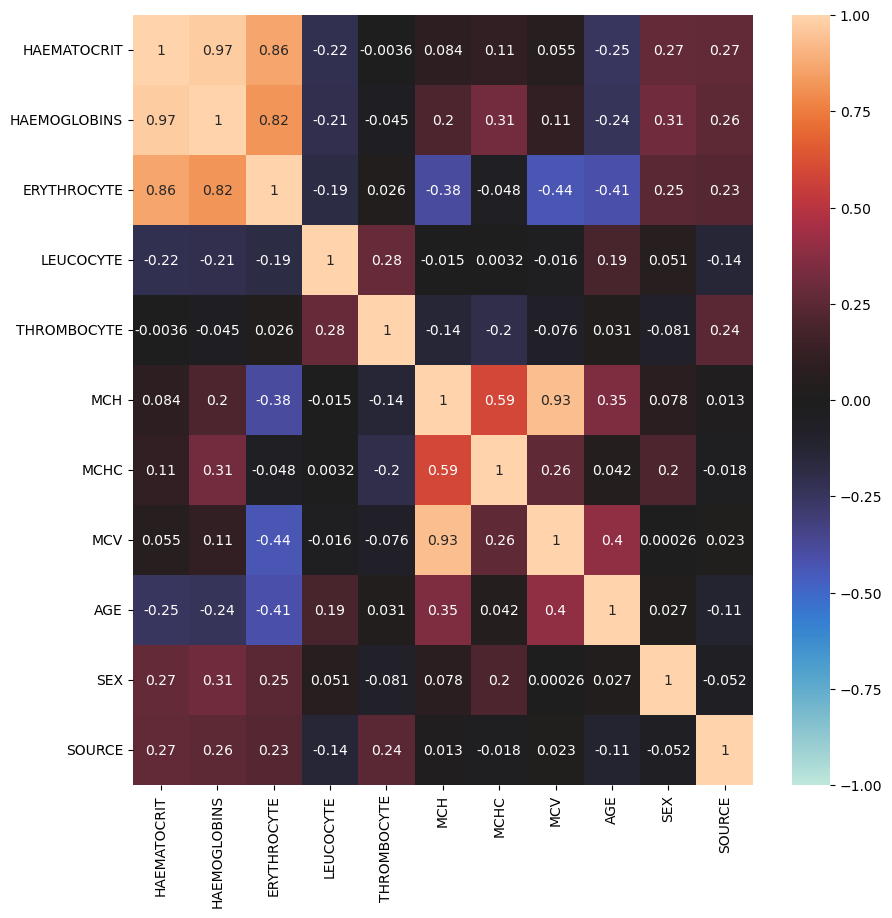

In [162]:
print ('\033[1mCorrelation Matrix'.center(80))
plt.figure(figsize=[10,10])
sns.heatmap(final_df.corr(),annot=True, vmin=-1, vmax=1, center=0)
plt.show()

# Checking correlation-based feature selection

# Random Forest Classification

In [163]:
from sklearn.ensemble import RandomForestClassifier

# Split data into features and target
X = final_df.drop('SOURCE', axis=1)
y = final_df['SOURCE']

classifier = RandomForestClassifier(n_estimators=100, criterion='gini')
classifier.fit(X_train, y_train)
rfc_acc = classifier.score(X_test, y_test)
print('Accuracy score',rfc_acc)    

Accuracy score 0.7605740181268882


# Support Vector Classifier 

In [164]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)
Y_Pred_svm = classifier.predict(X_test)

from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, Y_Pred_svm , target_names=target_names))
svc_acc = accuracy_score(y_test,Y_Pred_svm)
print("\nAccuracy Score:", svc_acc)

              precision    recall  f1-score   support

     class 0       0.75      0.50      0.60       540
     class 1       0.72      0.88      0.79       784

    accuracy                           0.73      1324
   macro avg       0.73      0.69      0.69      1324
weighted avg       0.73      0.73      0.71      1324


Accuracy Score: 0.7258308157099698


# Bagging Classifier 

In [165]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

dt = DecisionTreeClassifier(min_samples_leaf=8, random_state=1)
bc = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
bc_acc = accuracy_score(y_test, y_pred)
print('Test set accuracy of bc: {:.8f}'.format(bc_acc)) 

C:\Users\mingc\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Test set accuracy of bc: 0.75377644


# Gradient Boosting Classifier  

In [166]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
clf.fit(X_train, y_train)
Y_Pred_boost = clf.predict(X_test)
gbc_acc = accuracy_score(y_test, Y_Pred_boost)
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, Y_Pred_boost , target_names=target_names))
print('Accuracy Score: ',gbc_acc)

              precision    recall  f1-score   support

     class 0       0.70      0.61      0.65       540
     class 1       0.75      0.82      0.79       784

    accuracy                           0.73      1324
   macro avg       0.73      0.71      0.72      1324
weighted avg       0.73      0.73      0.73      1324

Accuracy Score:  0.7341389728096677


# ADA Boost Classifier 

In [167]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score    

model = DecisionTreeClassifier(criterion='entropy', max_depth=1)
AdaBoost = AdaBoostClassifier(base_estimator=model, n_estimators=50, learning_rate=1)
boostmodel = AdaBoost.fit(X_train, y_train)
y_pred_ada = boostmodel.predict(X_test)
ada_acc = accuracy_score(y_test,y_pred_ada)
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred_ada , target_names=target_names))
print('Accuracy Score: ',ada_acc)

C:\Users\mingc\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

     class 0       0.73      0.61      0.67       540
     class 1       0.76      0.85      0.80       784

    accuracy                           0.75      1324
   macro avg       0.75      0.73      0.73      1324
weighted avg       0.75      0.75      0.75      1324

Accuracy Score:  0.75


# KNN Classifier 

In [168]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
predic_knn=neigh.predict(X_test)
acc_test = accuracy_score(y_test, predic_knn)
print('Test set accuracy of bc: {:.8f}'.format(acc_test)) 

Test set accuracy of bc: 0.68580060


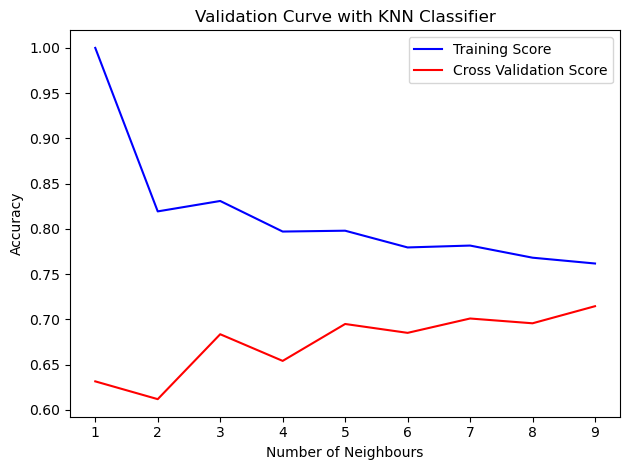

In [169]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
parameter_range = np.arange(1, 10, 1)
train_score, test_score = validation_curve(KNeighborsClassifier(), X_test, y_test,
                                       param_name = "n_neighbors",
                                       param_range = parameter_range,
                                        cv = 5, scoring = "accuracy")

mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

plt.plot(parameter_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score,
   label = "Cross Validation Score", color = 'r')

plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

# Naive Bayes Classification

In [170]:
import sklearn.naive_bayes as nb
from sklearn.metrics import accuracy_score

clf = nb.GaussianNB()
clf.fit(X_train, y_train)
Y_Pred_nb = clf.predict(X_test)
nb_acc = accuracy_score(y_test, Y_Pred_nb)
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, Y_Pred_nb , target_names=target_names))
print('Accuracy Score: ', nb_acc)

              precision    recall  f1-score   support

     class 0       0.66      0.48      0.55       540
     class 1       0.70      0.83      0.76       784

    accuracy                           0.69      1324
   macro avg       0.68      0.65      0.66      1324
weighted avg       0.68      0.69      0.67      1324

Accuracy Score:  0.6850453172205438


# Ridge Classification

In [171]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score

clf = RidgeClassifier(alpha=1.0)
clf.fit(X_train, y_train)
Y_Pred_ridge = clf.predict(X_test)
ridge_acc = accuracy_score(y_test, Y_Pred_ridge)
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, Y_Pred_ridge , target_names=target_names))
print('Accuracy Score: ', ridge_acc)

              precision    recall  f1-score   support

     class 0       0.75      0.49      0.59       540
     class 1       0.72      0.89      0.79       784

    accuracy                           0.73      1324
   macro avg       0.74      0.69      0.69      1324
weighted avg       0.73      0.73      0.71      1324

Accuracy Score:  0.7273413897280967


# Decision Tree Classification

In [172]:
import sklearn.tree as tree
from sklearn.metrics import accuracy_score

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
Y_Pred_dt = clf.predict(X_test)
dt_acc = accuracy_score(y_test, Y_Pred_dt)
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, Y_Pred_dt , target_names=target_names))
print('Accuracy Score: ', dt_acc)

              precision    recall  f1-score   support

     class 0       0.57      0.61      0.59       540
     class 1       0.72      0.68      0.70       784

    accuracy                           0.65      1324
   macro avg       0.64      0.65      0.64      1324
weighted avg       0.66      0.65      0.66      1324

Accuracy Score:  0.6533232628398792


# QDA Classification

In [173]:
import sklearn.discriminant_analysis as da
from sklearn.metrics import accuracy_score

clf = da.QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
Y_Pred_qda = clf.predict(X_test)
qda_acc = accuracy_score(y_test, Y_Pred_qda)
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, Y_Pred_qda , target_names=target_names))
print('Accuracy Score: ', qda_acc)

              precision    recall  f1-score   support

     class 0       0.72      0.53      0.61       540
     class 1       0.72      0.86      0.79       784

    accuracy                           0.72      1324
   macro avg       0.72      0.69      0.70      1324
weighted avg       0.72      0.72      0.71      1324

Accuracy Score:  0.722809667673716


# Extra Tree Classification

In [174]:
import sklearn.ensemble as ensemble
from sklearn.metrics import accuracy_score

clf = ensemble.ExtraTreesClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
Y_Pred_extra = clf.predict(X_test)
extra_acc = accuracy_score(y_test, Y_Pred_extra)
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, Y_Pred_extra, target_names=target_names))
print('Accuracy Score: ', extra_acc)

              precision    recall  f1-score   support

     class 0       0.75      0.64      0.69       540
     class 1       0.77      0.85      0.81       784

    accuracy                           0.77      1324
   macro avg       0.76      0.75      0.75      1324
weighted avg       0.76      0.77      0.76      1324

Accuracy Score:  0.7651057401812689


# LDA Classifier

In [175]:
import sklearn.discriminant_analysis as da
from sklearn.metrics import accuracy_score

clf = da.LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
Y_Pred_lda = clf.predict(X_test)
lda_acc = accuracy_score(y_test, Y_Pred_lda)
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, Y_Pred_lda , target_names=target_names))
print('Accuracy Score: ', lda_acc)

              precision    recall  f1-score   support

     class 0       0.75      0.49      0.60       540
     class 1       0.72      0.89      0.79       784

    accuracy                           0.73      1324
   macro avg       0.73      0.69      0.69      1324
weighted avg       0.73      0.73      0.71      1324

Accuracy Score:  0.7265861027190332


In [176]:
# Create comparison matrix of accuracy scores
Model_Evaluation_Comparison_Matrix = pd.DataFrame({'Model':['Random Forest Classifier','Support Vector Classifier','Bagging Classifier','Gradient Boosting Classifier','ADA Boost Classifier','K Neighbors Classifier','Naive Bayes Classifier','Ridge Classifier','Decision Tree Classifier','Quadratic Discriminant Analysis (QDA) Classifier','Extra Tree Classifier',' Linear Discriminant Analysis (LDA) Classifier']
                                                  ,0:[(rfc_acc*100),(svc_acc*100),(bc_acc*100),(gbc_acc*100),(ada_acc*100),(acc_test*100),(nb_acc*100),(ridge_acc*100),(dt_acc*100),(qda_acc*100),(extra_acc*100),(lda_acc*100)]})
Model_Evaluation_Comparison_Matrix= Model_Evaluation_Comparison_Matrix.rename(columns={0:'Accuracy Score'})
Model_Evaluation_Comparison_Matrix

,Model,Accuracy Score
0,Random Forest Classifier,76.057402
1,Support Vector Classifier,72.583082
2,Bagging Classifier,75.377644
3,Gradient Boosting Classifier,73.413897
4,ADA Boost Classifier,75.000000
5,K Neighbors Classifier,68.580060
6,Naive Bayes Classifier,68.504532
7,Ridge Classifier,72.734139
8,Decision Tree Classifier,65.332326
9,Quadratic Discriminant Analysis (QDA) Classifier,72.280967
